In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random

from support_functions import *

from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model

Using TensorFlow backend.


## Read Data

In [2]:
label_1_folder = [9,21]      # Images in this folder will be labeled as anomaly
target_folders = range(1,22) # Read these folders
data_path = "CroppedYale/"   # Source folder

# Read image matrix (n*m), labels (vector of m), and image size
imgs, labels, height, width = get_data(label_1_folder,target_folders,data_path)

578  images are above our threshold and thus removed from the list


## Visualize the result of Autoencoder
### Load the Model

In [5]:
autoencoder = load_model('model_autoencoder.h5')
# encoder = load_model('model_encoder.h5')

/Users/ivanzhou/General_Software/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


### Apply the model to the image data

/Users/ivanzhou/General_Software/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


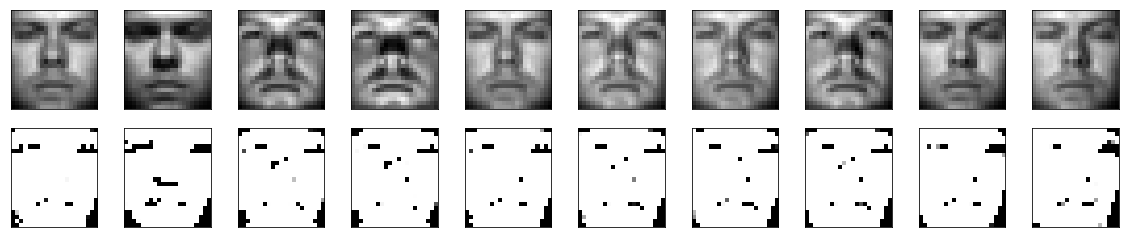

In [4]:
imgs_trans = np.transpose(imgs)
encoded_imgs = encoder.predict(imgs_trans)
# decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs = autoencoder.predict(imgs_trans)
# plot_compare_after_reconst(np.transpose(decoded_imgs),imgs,height,width)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs_trans[i].reshape(height, width))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(height, width))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()